# Fig 5: Analysis of mean-squared displacement

Here we generate the data for figure 5, which compares the mean-squared displacement between the OU model to a model with division noise

## Setup and Load data

In [154]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,Random,Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

k = 2
lw = 1

1

### Load experimental data

In [155]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_raw = data_raw[data_raw.length .>=9,:]
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);

df_gp = data_gp[data_gp.lineage .== lineages[3], :]
positions = unique(df_gp.position)
σλbar2 = var([mean(df_gp[df_gp.position .== p,:].matern32_flucs_x) for p in positions]);
σλbar2;

In [156]:
vars_data_raw = []
for l in lineages
    d = data_raw[data_raw.lineage .==l,:]
    v = var([(dp.lnM[end] - dp.lnM[1])/(dp.time[end] - dp.time[1]) for dp in groupby(d,:position)])
    push!(vars_data_raw,v)
end

### Load simulations

In [157]:

sims    = CSV.read("./../output/fig5_sims.csv", DataFrame)
sims_gp = CSV.read("./../output/fig5_sims_gp_preds.csv", DataFrame)

τ_range = unique(sims.τ)
D_range = unique(sims.D)

sort!(sims_gp, :lineage)

# --- 1) compute variance of λ per lineage in sims ---
# If λ can be missing, skipmissing handles it.
vλ = combine(groupby(sims, :lineage),
                     :λ => (x -> var(skipmissing(x))) => :sigmavar2)

# --- 2) add sigmavar2 to sims (repeated within each lineage) ---
sims = leftjoin(sims, vλ, on=:lineage)
# --- 3) add sigmavar2 to sims_gp (same value for each lineage) ---
sims_gp = leftjoin(sims_gp, vλ, on=:lineage)
sims_gp_dfs = groupby(sims_gp,[:D,:lineage]);



In [158]:
vs_gp = []
for d in groupby(sims_gp[sims_gp.lineage_original .==1,:],[:lineage,:D])
     positions = unique(d.position)
     push!(vs_gp,var([mean(d[d.position .== p,:].matern32notrend_flucs_x) for p in positions]));
end

vs_raw = []
for d in groupby(sims[sims.lineage_original .==1,:],[:lineage,:D])
     positions = unique(d.position)
     push!(vs_raw,var([mean(d[d.position .== p,:].λ) for p in positions]));
end


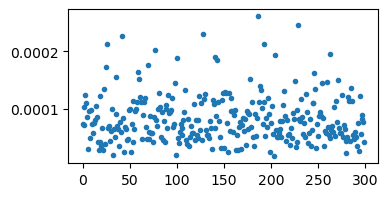

In [159]:
fig,ax = subplots(figsize=(4,2))
ax.plot(vs_raw,".",label="GP")
fig

In [160]:

vs_raw = []
for d in groupby(sims[sims.lineage_original .==1,:],[:lineage,:D])
     positions = unique(d.position)
     push!(vs_raw,var([mean(d[d.position .== p,:].lnM) for p in positions]));
end


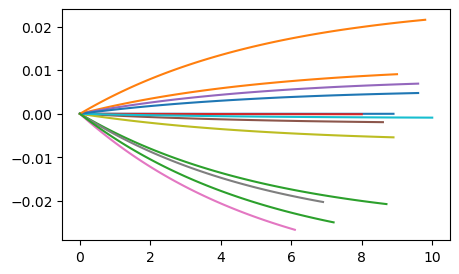

In [161]:
fig,ax = subplots(figsize=(5,3))
d = sims[sims.lineage .==5,:]
for pos in unique(d.position)
    dp = d[d.position .== pos,:]
    ax.plot(dp.time[1:end] .- dp.time[1],dp.λ[1:end] .- dp.λ[1],"-")
end
fig

In [162]:
any(ismissing, data_gp[!, :matern32_flucs])
Drange = unique(sims.D);

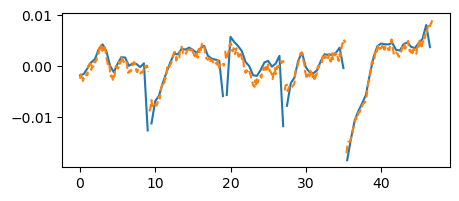

In [174]:
fig,ax = subplots(figsize=(5,2))

gp_lineages = unique(sims_gp.lineage)
d = sims_gp[sims_gp.lineage .== gp_lineages[20],:]
[ax.plot(dp.time,dp.matern32notrend_flucs_x .- mean(dp.matern32notrend_flucs_x),"C0") for dp in groupby(d,:position)[1:5]]
d = sims[sims.lineage .== gp_lineages[20],:]
[ax.plot(dp.time,dp.λ .- mean(dp.λ),"C1--") for dp in groupby(d,:position)[1:5]]
fig

# Mean-squared displacement

In [186]:

"""
Compute MSD_within(τ), MSD_between(τ), and MSD_ratio as in your screenshot.

Arguments
- df: DataFrame with columns time, position, and valuecol (λ).
- valuecol: Symbol for λ column (default :matern32notrend_flucs_x)
- timecol: Symbol for time column (default :time)
- poscol: Symbol for cell id column (default :position)
- taus: vector of τ lags (same units as `timecol`)
- avg_window: (τmin, τmax) window for the <MSD> averages used in the ratio

Returns
NamedTuple with:
- taus
- msd_within::Vector{Float64}
- msd_between::Vector{Float64}
- msd_ratio::Float64
"""
function msd_within_between_ratio(
    df;
    valuecol::Symbol = :matern32notrend_flucs_x,
    timecol::Symbol  = :time,
    poscol::Symbol   = :position,
    taus::AbstractVector,
    avg_window::Tuple{<:Real,<:Real} = (0.0, 4.0),
)

    # drop missings in needed cols and sort
    d = dropmissing(df, [timecol, poscol, valuecol])
    sort!(d, [poscol, timecol])

    # Group by cell (position)
    g = groupby(d, poscol)
    cell_ids = collect(keys(g))  # keys are NamedTuples like (position=...,)

    # Build fast lookup per cell: Dict(time -> λ), and record t0/tf
    λmap = Dict{Any, Dict{Float64, Float64}}()
    t0   = Dict{Any, Float64}()
    tf   = Dict{Any, Float64}()

    for key in cell_ids
        sub = g[key]
        times = Vector{Float64}(sub[!, timecol])
        vals  = Vector{Float64}(sub[!, valuecol])
        λmap[key] = Dict(times .=> vals)
        t0[key] = first(times)
        tf[key] = last(times)
    end

    # Helper: for each cell i, find the unique "next" cell j with t0[j] > tf[i]
    function next_cell(key_i)
        ti_end = tf[key_i]
        candidates = Any[]
        for key_j in cell_ids
            if t0[key_j] > ti_end
                push!(candidates, key_j)
            end
        end
        isempty(candidates) && return nothing
        # choose the one with smallest t0
        j = candidates[argmin([t0[k] for k in candidates])]
        return j
    end

    msd_within  = fill(NaN, length(taus))
    msd_between = fill(NaN, length(taus))

    # --- MSD_within(τ) ---
    # MSD_within(τ) = (1/k) Σ_i (1/N_i) Σ_t (λ_i(t+τ) - λ_i(t))^2
    # here we implement the pooled version consistent with Eq (16): average over cells of per-cell MSD.
    for (kτ, τ) in pairs(taus)
        percell = Float64[]
        for key in cell_ids
            m = λmap[key]
            acc = 0.0
            cnt = 0
            for (t, λt) in m
                t2 = t + float(τ)
                λt2 = get(m, t2, NaN)
                if !isnan(λt2)
                    acc += (λt2 - λt)^2
                    cnt += 1
                end
            end
            if cnt > 0
                push!(percell, acc / cnt)
            end
        end
        msd_within[kτ] = isempty(percell) ? NaN : mean(percell)
    end

    # --- MSD_between(τ) ---
    # MSD_between(τ) = (1/N_between) Σ_i (1/N_i) Σ_t (λ_j(t+τ) - λ_i(t))^2, with j ≠ i
    # using the "sequential" rule: j = next cell after i (t0[j] > tf[i]), if it exists.
    for (kτ, τ) in pairs(taus)
        percell = Float64[]
        for key_i in cell_ids
            key_j = next_cell(key_i)
            key_j === nothing && continue
            mi = λmap[key_i]
            mj = λmap[key_j]
            acc = 0.0
            cnt = 0
            for (t, λi) in mi
                t2 = t + float(τ)
                λj = get(mj, t2, NaN)
                if !isnan(λj)
                    acc += (λj - λi)^2
                    cnt += 1
                end
            end
            if cnt > 0
                push!(percell, acc / cnt)
            end
        end
        msd_between[kτ] = isempty(percell) ? NaN : mean(percell)
    end

    # --- MSD ratio ---
    τmin, τmax = avg_window
    idx = findall(τ -> (τ >= τmin && τ <= τmax), taus)

    # If some τ have NaNs, drop them in the averaging step
    bw = [msd_between[i] for i in idx if !isnan(msd_between[i])]
    wi = [msd_within[i]  for i in idx if !isnan(msd_within[i])]

    msd_ratio = (isempty(bw) || isempty(wi)) ? NaN :
        (mean(bw) / (mean(bw) + mean(wi)))

    return (taus = collect(taus),
            msd_within = msd_within,
            msd_between = msd_between,
            msd_ratio = msd_ratio)
end


function msdr(d,col)
    taus = 0.5:0.5:8.0
    out = msd_within_between_ratio(
        d;
        valuecol = col,
        timecol  = :time,
        poscol   = :position,
        taus     = taus,
        avg_window = (0.0, 4.0),
    )
    return out.msd_ratio
end


msdr (generic function with 1 method)

In [187]:
msdrs = [msdr(d,:matern32notrend_flucs_x) for d in sims_gp_dfs]
Ds = [d.D[1] for d in groupby(sims_gp,:lineage)]

# put vars and Ds in dataframe 
#Ds = [d.D[1] for d in sims_gp_dfs]
msd_df = DataFrame(D = Ds, msd = msdrs)
γ = 1/5.4
Td = 8.7
s2 = (2 .* msd_df.D) ./ (γ.^2 .* Td.^2) .* (Td .- (1 ./ γ) .* (1 .- exp.(-γ .* Td)))
msd_df.ratio = s2 ./ σλbar2;

msdr_comb = combine(groupby(msd_df,:ratio),:msd => mean => :msd_mean);
msd_data = [msdr(d,:matern32_flucs_x) for d in groupby(data_gp,:lineage)];

# save msd_df,msdr_comb and msd_data to csv files 
msd_df |> CSV.write("./../output/fig5_msd_df.csv")
msdr_comb |> CSV.write("./../output/fig5_msdr_comb.csv")
CSV.write("./../output/fig5_msd_data.csv", DataFrame(msd_data = msd_data))


"./../output/fig5_msd_data.csv"

In [216]:
σλbar2

9.102042139576125e-5

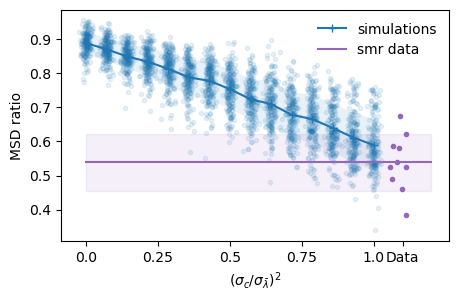

In [189]:
fig,ax = subplots(figsize=(5,3))

ratios, msdr_mean = msdr_comb.ratio, msdr_comb.msd_mean
msdr_err = [std(d.msd) for d in groupby(msd_df,:ratio)]
ax.plot(ratios, msdr_mean, "+-", label="simulations")
ax.fill_between(ratios , msdr_mean .- msdr_err, msdr_mean .+ msdr_err, alpha=0.1)
[ax.plot(d.ratio[1]  .* ones(length(d.msd)) .+ rand(Normal(0.0,0.01), length(d.msd)), d.msd , "C0.", alpha=0.1) for d in groupby(msd_df,:ratio)]

# data points
ax.plot(1.1 .+ rand(Normal(0.0,0.02), length(msd_data)), msd_data, "C4.")


ax.plot([0.0,1.2], [mean(msd_data), mean(msd_data)], "C4-", label="smr data")
msdr_mean_data, msdr_err_data = mean(msd_data), std(msd_data)
ax.fill_between([0.0,1.2], msdr_mean_data .- msdr_err_data, msdr_mean_data .+ msdr_err_data, alpha=0.1, color="C4")
ax.set_xticks(vcat(collect(0:0.25:1.0),[1.1]))
ax.set_xticklabels(vcat(collect(0:0.25:1.0),["Data"]))
ax.legend(frameon=false)
ax.set_ylabel("MSD ratio")
ax.set_xlabel(L"(\sigma_c/\sigma_{\bar{\lambda}})^2")
fig

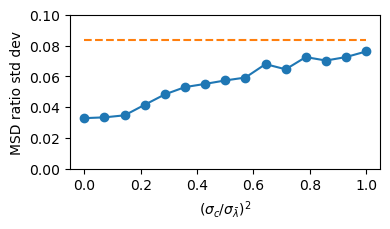

In [209]:
fig,ax = subplots(figsize=(4,2))
ax.plot(ratios,msdr_err,"o-")
ax.plot([0,1],[msdr_err_data,msdr_err_data],"--")
ax.set_ylim([0.00,0.1])
ax.set_xlabel(L"(\sigma_c/\sigma_{\bar{\lambda}})^2")
ax.set_ylabel("MSD ratio std dev")
fig

# Variance scaling

In [191]:
function var_lnM_across_positions_alt(df,col,min_age)
    positions = unique(df.position)
    df[:,:age_normed] = vcat([df[df.position .==p,:age] for p in positions]...);
    df[:,:age_rounded] = round.(df[:,:age_normed],digits=1);
    #df[:,:age] = df.age_rounded
    df.y = vcat([df[df.position .==pos,col] .- df[df.position .==pos,col][1]
        for pos in unique(df.position)]...) ./ df.age
    df_var = combine(groupby(df,:age_rounded),:y => var => :var,:age => mean => :age)
    return df_var.age[df_var.age .> min_age],df_var.var[df_var.age .> min_age]
end

"""
    var_lnM_across_positions(d)

Compute the variance across positions of lnM trajectories
for a single lineage dataframe `d`.

Returns:
    t        :: Vector
    var_lnM  :: Vector
"""

function var_lnM_across_positions(d::AbstractDataFrame, col::Symbol, min_age)
    min_ind = 1
    if any(ismissing, d[!, col])
        error("Column $(col) contains missing values.")
    end

    positions = unique(d.position)

    # compute usable length starting at min_ind (after sorting)
    nt = minimum(
        let dp = sort(d[d.position .== pos, :], :time)
            nrow(dp) - (min_ind - 1)
        end
        for pos in positions
    )

    @assert nt > 0 "Not enough points per position: need nrow(dp) ≥ $(min_ind) after sorting."

    np = length(positions)
    X = Matrix{Float64}(undef, np, nt)

    # reference time grid (truncated)
    ref = sort(d[d.position .== positions[1], :], :time)
    idx = min_ind:(min_ind + nt - 1)
    t = ref.time[idx] .- ref.time[1]

    for (i, pos) in enumerate(positions)
        dp = sort(d[d.position .== pos, :], :time)

        vals = dp[!, col]
        base = vals[1]                 # keep your original baseline
        # base = vals[min_ind]         # uncomment if you want baseline at min_ind instead

        truncated = vals[idx]

        X[i, :] .= truncated .- base
    end

    var_lnM = vec(var(X, dims=1))
    return t[t .> min_age], var_lnM[t .> min_age]
end
function variance_scaling_exponent(df,col,min_age)
    x,y = var_lnM_across_positions(df,col,min_age)
    x,y = log.(x), log.(y) 
    slope =  cov(x,y)/var(x)
    inter = mean(y) - slope .* mean(x)
    return slope 
end

function variance_scaling_exponent_alt(df,col,min_age)
    x,y = var_lnM_across_positions_alt(df,col,min_age)
    x,y = log.(x), log.(y) 
    slope =  cov(x,y)/var(x)
    inter = mean(y) - slope .* mean(x)
    return slope 
end


# MOVE TO UTils
function solve_D_σz_from_s2_and_varbar(γ, Td, s2, varbar)
    A = Td - (1/γ) * (1 - exp(-γ*Td))                # bracket term
    if A <= 0
        error("Invalid parameters: A = Td - (1/γ)(1-exp(-γ Td)) must be positive.")
    end

    D = (γ^2 * Td^2 / (2*A)) * s2

    Δ = varbar - s2                                   # remainder attributed to σz-term
    if Δ < 0
        error("Inconsistent inputs: varbar - s2 is negative (got $(Δ)).")
    end

    denom = abs(1 - exp(-γ*Td))
    σz = (γ * Td / denom) * sqrt(Δ)

    return D, σz
end

solve_D_σz_from_s2_and_varbar (generic function with 1 method)

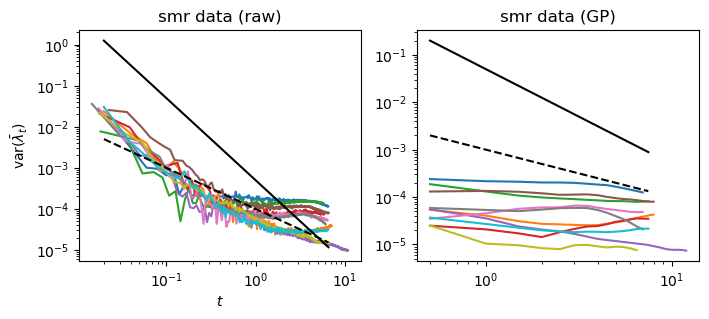

In [194]:
fig,axs = subplots(figsize=(8,3),ncols=2)
min_age = 0.0
ax = axs[0]
ax.set_title("smr data (raw)")
x = 0.
data_raw_gplins = vcat([data_raw[data_raw.lineage .== l,:] for l in unique(data_gp.lineage)]...)
for d in groupby(data_raw_gplins,:lineage)
    x,y = var_lnM_across_positions(d,:lnM,min_age)
    ax.loglog(x,y ./ x .^2 ,"-")
end
ax.plot(x, 0.0001 ./ x,"k--",label=L"$t$")
ax.plot(x, 0.0005 ./ x .^2,"k-",label=L"$t^2$")
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")
ax.set_xlabel(L"t")


ax = axs[1]
min_age = 0.0
ax.set_title("smr data (GP)")
x = 0.
for d in groupby(data_gp,:lineage)
    x,y = var_lnM_across_positions(d,:matern32_flucs,min_age)
    ax.loglog(x,y ./ x .^2 ,"-")
end
ax.plot(x, 0.001 ./ x,"k--")
ax.plot(x, 0.05 ./ x .^2,"k-")
#ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")
savefig("./../figures/PAPER_FIG5-msd_alt.pdf")
fig

# Additional figures

In [126]:

fig,axs = subplots(figsize=(6,6),ncols=2,nrows=2)
for d in groupby(sims[sims.D .== Drange[1],:],:lineage)[1:6]
    d.lnMhat .= d.lnM .+ rand(Normal(0.0,0.01), nrow(d))
    x,y = var_lnM_across_positions(d,:lnMhat,min_age)
    ax.loglog(x,y ./ x.^2  ,"C$i-")
    i +=1
end


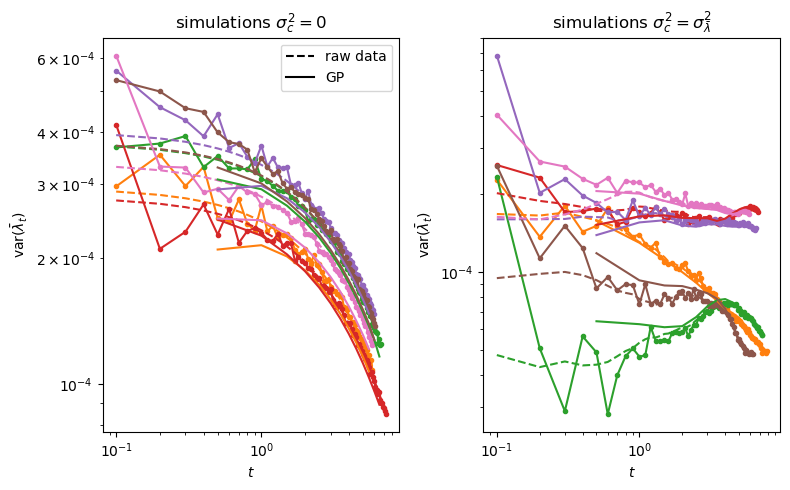

In [215]:
fig,axs = subplots(figsize=(8,5),ncols=2)
min_age = 0.
ax = axs[0]
ax.set_title(L"simulations $\sigma_c^2 = 0$")
x =0
i = 1
for d in groupby(sims[sims.D .== Drange[1],:],:lineage)[1:6]
    d.lnMhat .= d.lnM .+ rand(Normal(0.0,0.001), nrow(d))
    x,y = var_lnM_across_positions(d,:lnMhat,min_age)
    ax.loglog(x,y ./ x.^2  ,"C$i.-")

    x,y = var_lnM_across_positions(d,:lnM,min_age)
    ax.loglog(x,y ./ x.^2  ,"C$i--")
    i +=1
end

#ax.plot([1],[10e-5],"k.-",label="noisy data")
ax.plot([1],[10e-5],"k--",label="raw data")
ax.plot([1],[10e-5],"k-",label="GP")
ax.legend(frameon=false)
i = 1
for d in groupby(sims_gp[sims_gp.D .== Drange[1],:],:lineage)[1:6]
    x,y = var_lnM_across_positions(d,:matern32notrend_flucs,min_age)
    ax.loglog(x,y ./ x .^2 ,"C$i-")
    i+=1
end
# ax.plot(x, 0.0001 ./ x,"k--",label=L"$t$")
# ax.plot(x, 0.0005 ./ x .^2,"k-",label=L"$t^2$")
ax.legend()
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")
ax.set_xlabel(L"t")

ax = axs[1]
ax.set_title(L"simulations $\sigma_c^2 = \sigma_{\bar{\lambda}}^2$")
i = 1
for d in groupby(sims[sims.D .== Drange[end],:],:lineage)[1:6]
    d.lnMhat .= d.lnM .+ rand(Normal(0.0,0.001), nrow(d))
    x,y = var_lnM_across_positions(d,:lnMhat,min_age)
    ax.loglog(x,y ./ x.^2  ,"C$i.-")

    x,y = var_lnM_across_positions(d,:lnM,min_age)
    ax.loglog(x,y ./ x.^2  ,"C$i--")
    i +=1
end

i = 1
for d in groupby(sims_gp[sims_gp.D .== Drange[end],:],:lineage)[1:6]
    x,y = var_lnM_across_positions(d,:matern32notrend_flucs,min_age)
    ax.loglog(x,y ./ x .^2 ,"C$i-")
    i+=1
end
# ax.plot(x, 0.0001 ./ x,"k--")
# ax.plot(x, 0.0005 ./ x .^2,"k-")
ax.legend(frameon=false)
ax.set_ylabel(L"${\rm var}(\bar{\lambda}_t)$")
ax.set_xlabel(L"t")



tight_layout()
fig

In [206]:
log.([0.01,2.,0.00001])

3-element Vector{Float64}:
  -4.605170185988091
   0.6931471805599453
 -11.512925464970229

In [207]:
0.00001

1.0e-5

In [128]:
fig,axs = subplots(figsize=(6,6))
min_age = 0.5
ax = axs[0,0]
ax.set_title(L"simulations $\sigma_c^2 = 0$")
x =0
i = 1
for lin in unique(sims_gp[sims_gp.D .== Drange[1],:].lineage)[1:6]
    d = sims[sims.lineage .== lin,:]
    d.lnMhat .= d.lnM .+ rand(Normal(0.0,0.01), nrow(d))
    x,y_raw = var_lnM_across_positions(d,:lnMhat,min_age)
    ax.loglog(y_raw,  ,"C$i-")
    i +=1
end


PythonCall.Core.PyException: Python: TypeError: 'Axes' object is not subscriptable

In [129]:
min_age = 2.5
vars = [variance_scaling_exponent(d,:matern32notrend_flucs,min_age) for d in sims_gp_dfs]
vars = [variance_scaling_exponent(d,:lnM,min_age) for d in groupby(sims,:lineage)]
Ds = [d.D[1] for d in groupby(sims,:lineage)]
vars_data = [variance_scaling_exponent(d,:matern32_flucs,min_age) for d in groupby(data_gp,:lineage)]
vars_data = [variance_scaling_exponent(d,:lnM,min_age) for d in groupby(data_raw_gplins,:lineage)]

# put vars and Ds in dataframe 
#Ds = [d.D[1] for d in sims_gp_dfs]
vars_df = DataFrame(D = Ds, var = vars)
γ = 1/5.4
Td = 8.7
s2 = (2 .* vars_df.D) ./ (γ.^2 .* Td.^2) .* (Td .- (1 ./ γ) .* (1 .- exp.(-γ .* Td)))
vars_df.ratio = s2 ./ σλbar2;


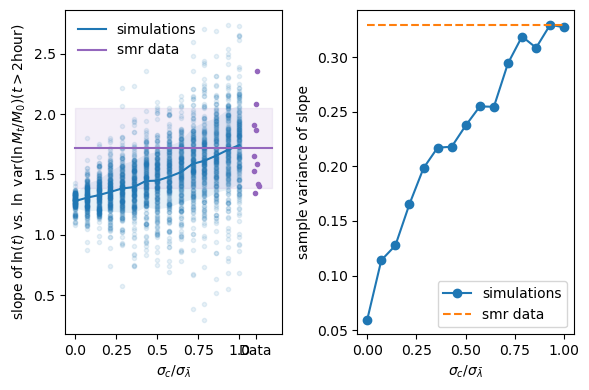

In [208]:
vars_comb = combine(groupby(vars_df,:ratio),:var => mean => :var_mean)
fig,axs= subplots(figsize=(6,4),ncols=2)

ax = axs[0]
ratios, vm= vars_comb.ratio,vars_comb.var_mean
verr = [std(d.var) for d in groupby(vars_df,:ratio)]
ax.plot(ratios,vm,"-",label="simulations")
ax.fill_between(ratios,vm .- verr,vm .+ verr,alpha=0.1)
[ax.plot(d.ratio[1] .* ones(length(d.var)),d.var,"C0.",alpha=0.1) for d in groupby(vars_df,:ratio)]
ax.plot(1.1 .+ rand(Normal(0.0,0.01),length(vars_data)),vars_data,"C4.")
ax.plot([0.0,1.2], [mean(vars_data),mean(vars_data)],"C4-",label="smr data")
vm,verr = mean(vars_data),std(vars_data)
ax.fill_between([0.0,1.2],vm .- verr,vm .+ verr,alpha=0.1,color="C4")
ax.set_xticks(vcat(collect(0:0.25:1.0),[1.1]))
ax.set_xticklabels(vcat(collect(0:0.25:1.0),["Data"]))
#ax.set_ylim([1.5,2.2])
ax.legend(frameon=false)
ax.set_ylabel(L"\text{slope of}\, \ln (t) \text{ vs. }\ln \text{ var}(\ln M_t/M_0) (t > 2 {\rm hour})")
ax.set_xlabel(L"\sigma_c/\sigma_{\bar{\lambda}}")

ax = axs[1]
ax.plot(ratios,[std(d.var) for d in groupby(vars_df,:ratio)],"o-",label="simulations")
ax.plot(ratios,ones(length(ratios)) .* std(vars_data),"--",label="smr data")
ax.set_ylabel("sample variance of slope")
ax.set_xlabel(L"\sigma_c/\sigma_{\bar{\lambda}}")
ax.legend()

tight_layout()
fig

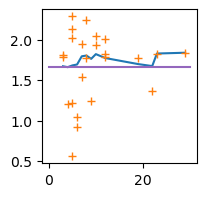

In [86]:
vars_data_vlength = [mean([variance_scaling_exponent(d,:lnM,min_age) for d in groupby(data_raw[data_raw.length .>= k,:],:lineage)]) for k in sort(unique(data_raw.length))];
lengths =  sort(unique(data_raw.length))
fig,ax= subplots(figsize=(2,2))
ax.plot(lengths,vars_data_vlength,"-")
ax.plot([d.length[1] for d in groupby(data_raw,:lineage)],[variance_scaling_exponent(d,:lnM,min_age) for d in groupby(data_raw,:lineage)],"+")
ax.plot([0.0,30], [mean(vars_data),mean(vars_data)],"C4-",label="smr data")
fig